In [18]:
from pycaret.datasets import get_data
import pandas as pd
from pycaret.regression import *
import pandas_profiling as pp
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
from summarytools import dfSummary
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

### Carga de Datos

In [19]:
#cargamos el dataset
data_house_prices = pd.read_csv('../data/raw/house_prices_train.csv')

### Split de los datos (testing y training)

In [20]:
num_files_train = int(len(data_house_prices)*0.8)

data_train = data_house_prices.sample(n=num_files_train, random_state=2023)
data_test = data_house_prices.drop(data_train.index)

In [21]:
print(f"Filas en Train: {data_train.shape[0]}")
print(f"Filas en Test: {data_test.shape[0]}")

Filas en Train: 1168
Filas en Test: 292


### Exploratory Data Analysis

In [22]:
data_house_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [23]:
dfSummary(data_house_prices)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,Id[int64],Mean (sd) : 730.5 (421.6)min < med < max:1.0 < 730.5 < 1460.0IQR (CV) : 729.5 (1.7),"1,460 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKQAAABACAYAAACUYNzVAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjYuMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy89olMNAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABUklEQVR4nO3WsUrDUBTH4ZPSC1ahAae8lmOfsKMP1aWL1Eilm3FxyNBW2sU/8n1LhsO5N8OPkG6apoIUi79+AZhbXhp0XbeoqvWd53Y/z3s+v3b/925V1cc0TV/nBheDrKr1ZrN56fv+dOttu93uubXWDcPwZtfu3DiOq+12+1pV7+fm14Ksvu9PwzB83nrp4XB4bK2VXbu38g9JFEESRZBEESRRBEkUQRJFkEQRJFEESRRBEkWQRBEkUQRJFEESRZBEESRRBEkUQRJFkEQRJFEESRRBEkWQRBEkUQRJFEESRZBEESRRBEkUQRJFkEQRJFEESRRBEkWQRBEkUQRJFEESRZBEESRRBEkUQRJFkEQRJFEESRRBEkWQRBEkUQRJFEESRZBEESRRBEkUQRJFkEQRJFEESRRBEmV5bTiO4+qeQ4/H40Nrrdvv90927c791tQ3ucefRh4PyjAAAAAASUVORK5CYII="">",0(0.0%)
2,MSSubClass[int64],Mean (sd) : 56.9 (42.3)min < med < max:20.0 < 50.0 < 190.0IQR (CV) : 50.0 (1.3),15 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKQAAABACAYAAACUYNzVAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjYuMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy89olMNAAAACXBIWXMAAA9hAAAPYQGoP6dpAAAB0klEQVR4nO3csW7CMBhF4d+oSKWNsNQpD9UhHXlCxj4UC0uVJkqBhaQLAwsp2Lhc8PlW5GDBEXISYjcMgwEqJreeAHDs6dQLzrmJmc0jjt0Ow9BHjEeGTgZpZvPFYvHhvd9eetCmaWbL5fLTzL6DZ4YsjQVp3vttWZY//zUZgDUkpBAkpBAkpBAkpBAkpBAkpBAkpBAkpBAkpBAkpBAkpBAkpBAkpBAkpBAkpBAkpBAkpBAkpBAkpBAkpBAkpBAkpIw+BnsLbFCQN7kgjQ0KsqYYJBsUZIw1JKQQJKQQJKQQJKQQJKQQJKQQJKQQJKQQJKQQJKQQJKQQJKQQJKQQJKQQJKQQJKQQJKQk+cf4fr93ZuadcyHDfd/3QQNx/5IE2bbtrKqq97Isvy4du1qt3jabzc7MugRTg7hkz9QURRH0XExd1y8p5oP7wBoSUggSUggSUggSUiQ3CggVebnJLHAbFrZ/uZ6HCjLmclPkNixs/3IlDxWkWfjlplhs/3IdDxckzqO6zCDIgwxvd0ouMwjyIMfbnaHLjJQnjwR5hNud50l58kiQCJLq5JEL45Ay+gvZNM0s5KBd1z1Pp1O3Xq9fGTvu8BnHrMdC+Vt8v3+95y9RTM9OTpePYwAAAABJRU5ErkJggg=="">",0(0.0%)
3,MSZoning[object],1. RL2. RM3. FV4. RH5. C (all),"1,151 (78.8%)218 (14.9%)65 (4.5%)16 (1.1%)10 (0.7%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABzCAYAAACPdnBjAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjYuMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy89olMNAAAACXBIWXMAAA9hAAAPYQGoP6dpAAAB9klEQVR4nO3dscrTYBSA4aQUpIv5x95Uh47xBjt6a0aQ4mKcBBF/XJo3xT7PFRzoCznDd+i4rusAhcPeA/A6xEZGbGTGYRje9h6CxNd1XX/sOcBxnufrNE33PYdgW8uynG632+dhGL7sOcdxmqb7+Xz+tucQvAY7GxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkTkuy3Laewi29Sy/sZe6r2P3l7qjUz4qdjYyYiOz9c62+57A89jsuupZLnp4Hq6ryNjZyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNzGbXVc9y0cPz8FKXjOsqMnY2MmIj86+dzc7Fw7x7XeU6ikdzXUXGzkZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTeva5yHcWjealLxnUVGTsbmd8/oz6ZbOowz/N1nufrMAwf9x6G/9txi/+tgr+xs5ERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkdnsv6vgT56Fk3FdRcbORuYwjuPbOI6iY3OHy+XyaXBZReBwOp2+7z0Er8Hnk4zYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNzOF+v3/Yewhew6/rKpdVbM51FRk7GxmxkREbmZ87v38JNDlubgAAAABJRU5ErkJggg=="">",0(0.0%)
4,LotFrontage[float64],Mean (sd) : 70.0 (24.3)min < med < max:21.0 < 69.0 < 313.0IQR (CV) : 21.0 (2.9),110 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKQAAABACAYAAACUYNzVAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjYuMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy89olMNAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABxklEQVR4nO3dMWsCMRyG8X+k0tqKsZ3uEzl1sNDFT+jYQfqJBHEp5x1Xr4uXrl0ULnr0zd3zWyUhwwOGQHIuhGCAitF/LwD4666LSZ1zIzObXTFFGUJobrUepKOTIM1stlqt3rz3dduBRVFM1uv1h5kdbr8sqOsqSPPe11mWfXc1P/qJPSSkECSkECSkECSkECSkECSkECSkECSkECSkECSkECSkECSkECSkECSkECSkECSkECSkECSkECSkECSkECSkECSkECSkECSkECSkECSkECSkECSkECSkECSkdPYcX6zT6eTMzDvnYqfgsdOEyQVZluVkuVy+Zln21XYsj52mTy5IM7PpdMpjpwPFHhJSCBJSCBJSCBJSCBJSCBJSzh77XPk1Lt80TfTJNobr0jlk9Ne4ttvty/F4/DGzKn5pGKKLB+OxX+PK8/wxfkkYMvaQkEKQkEKQkEKQkEKQkEKQkEKQkEKQkEKQkEKQkEKQkEKQkCJ56zAWd7rT16sgudOdvl4Facad7tT1LshY/N1ruBhkURSTmEmrqnoYj8duv98/pTJ2t9s9LxaL9/l8fmg7tq7r+81m8+mcK9qOHaIQwuHcb78n8n4eMTI9GwAAAABJRU5ErkJggg=="">",259(17.7%)
5,LotArea[int64],Mean (sd) : 10516.8 (9981.3)min < med < max:1300.0 < 9478.5 < 215245.0IQR (CV) : 4048.0 (1.1),"1,073 distinct va

In [24]:
#función para categorizar las variables 
def getColumnTypes(dataset):
     ''' Descripcion: Esta función extrae el tipo de dominio de las columnas de un dataset.
         Entradas: Pandas Dataframe  
         Salida: Tupla con arreglo que contine nombres de las columnas. '''
     
     continuas = []
     discretas = []
     categoricas = []
     for col in dataset.columns:
          if((dataset[col].dtype == 'int64') or (dataset[col].dtype == 'float64')):
               if(len(dataset[col].unique()) > 30): #criterio para discretas o continuas
                    continuas.append(col)
               else:
                    discretas.append(col)
          else:
               categoricas.append(col)

     return continuas, discretas, categoricas

In [25]:
continuas, discretas, categoricas = getColumnTypes(data_house_prices)
print(f'{continuas = }')
print(f'{discretas = }')
print(f'{categoricas = }')

continuas = ['Id', 'LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageYrBlt', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'ScreenPorch', 'SalePrice']
discretas = ['MSSubClass', 'OverallQual', 'OverallCond', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', '3SsnPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']
categoricas = ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQ

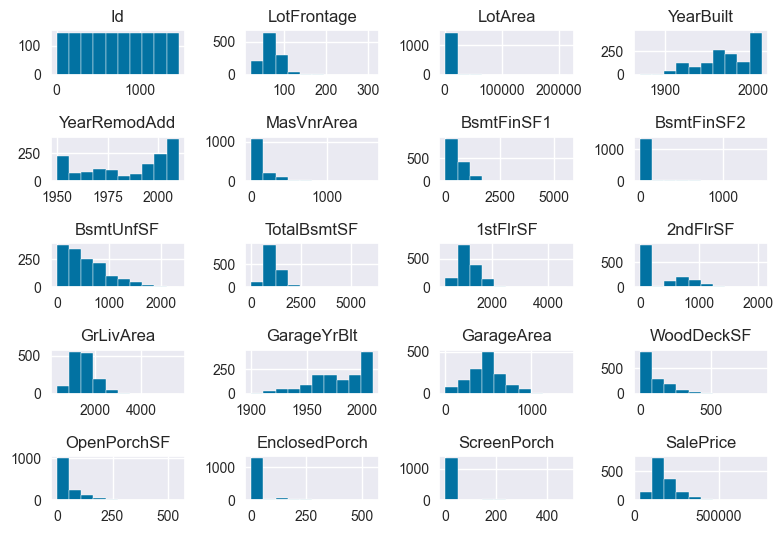

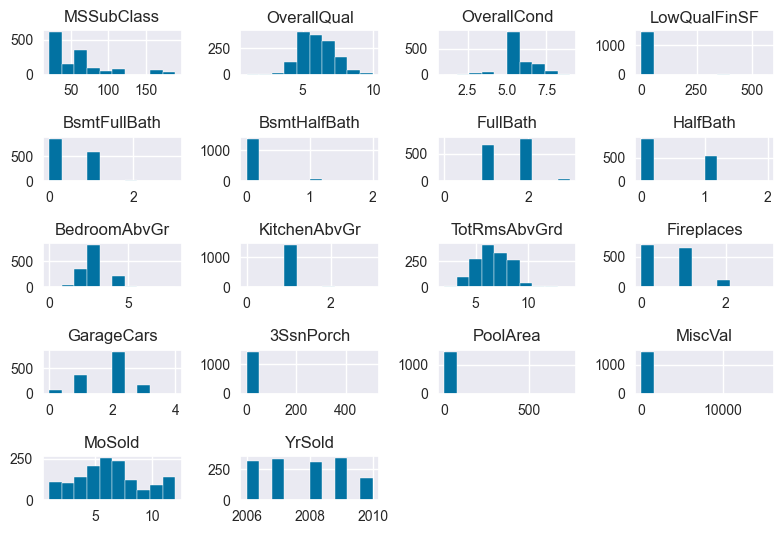

In [26]:
#histogramas de variables numericas 
sns.set_style('darkgrid')
data_house_prices[continuas].hist()
plt.tight_layout()
plt.show()

data_house_prices[discretas].hist()
plt.tight_layout()
plt.show()

### Profiling

In [27]:
profile = pp.ProfileReport(data_house_prices)
profile.to_file('..\docs\profile_min.json')

#ver archivo json en la carpeta docs, el renderizado toma mucho tiempo y recursos tanto aca como en formato html y por consecuencia no se muestra en su totalidad.

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Render JSON:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [28]:
#evaluando valores faltantes 
missing_vals = data_house_prices.isnull().sum()
columns_missing_vals = missing_vals[missing_vals > 0]
columns_missing_vals

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

Para este dataset en particular no vamos a remover ninguna columna de las que se listan acá, cada una tiene alguna característica que puede ser importante para determinar el precio de una propiedad. 

### Setup

In [29]:
dataset = setup(data=data_train,                        #dataset de training
                target='SalePrice',                     #variable dependiente
                session_id=2023,                        #session id especifico
                normalize=True,                         #determina si se va a utilizar feature scaling (normalization) 
                transformation=True,                    #permite que se apliquen varias transformaciones al dataset (faltantes, encoding, etc.)
                log_experiment=True,                    #guardar un log del experimento
                experiment_name='Sale_Price_v1',        #nombre del experimento
                ignore_features=['Id'],                 #ignora las columnas listadas, el id no nos representa un dato significativo 
                remove_multicollinearity = True,        #remover multicolinealidad, existe una gran cantidad de alertas en el profiling sobre alta colinealidad.  
                numeric_imputation=0,                   #reemplaza los valores numericos faltantes por un 0, ya que son las cantidades de X caracteristica de la propiedad
                categorical_imputation='N/A'            #reemplaza los valores categoricos por N/A, ya que sino hay valores quiere decir que la propiedad no posee dicha caracteristica  
                )

,Description,Value
0,Session id,2023
1,Target,SalePrice
2,Target type,Regression
3,Original data shape,"(1168, 81)"
4,Transformed data shape,"(1168, 266)"
5,Transformed train set shape,"(817, 266)"
6,Transformed test set shape,"(351, 266)"
7,Ignore features,1
8,Ordinal features,6
9,Numeric features,36


2023/11/26 08:48:20 INFO mlflow.tracking.fluent: Experiment with name 'Sale_Price_v1' does not exist. Creating a new experiment.


### Comparando modelos

In [30]:
# Comparar modelos y seleccionar los tres mejores
top3 = compare_models(n_select=3)

# Imprimir los modelos seleccionados
print(top3)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,17193.9936,771519086.4130,26188.2240,0.8659,0.1394,0.1019,0.6720
lightgbm,Light Gradient Boosting Machine,17799.6734,873304810.7908,28390.5482,0.8475,0.1455,0.1034,0.7430
rf,Random Forest Regressor,18430.5320,893253168.8116,28642.2567,0.8450,0.1515,0.1096,1.0130
et,Extra Trees Regressor,19554.1126,977741238.7974,30307.6230,0.8357,0.1525,0.1124,0.8960
en,Elastic Net,19487.2529,1065256898.6520,31440.6048,0.8160,0.1572,0.1113,0.5310
br,Bayesian Ridge,20083.5996,1105637601.5382,31678.5771,0.8061,0.1903,0.1184,0.4740
par,Passive Aggressive Regressor,19585.0552,1139595514.2704,32174.1291,0.8014,0.1637,0.1140,0.6220
omp,Orthogonal Matching Pursuit,21167.6448,1151069563.8980,32731.6181,0.7984,0.2082,0.1299,0.4940
huber,Huber Regressor,20060.7998,1168758324.9236,32099.4714,0.7948,0.1704,0.1197,0.5660
ada,AdaBoost Regressor,24272.7146,1252497484.3915,34616.6504,0.7834,0.1936,0.1539,0.5790


[GradientBoostingRegressor(random_state=2023), LGBMRegressor(n_jobs=-1, random_state=2023), RandomForestRegressor(n_jobs=-1, random_state=2023)]


### Gráfica de importancia de características

Nombre del modelo: GradientBoostingRegressor(random_state=2023)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,24352.7230,2570492282.0715,50700.0225,0.4942,0.2339,0.1585
1,16448.9799,513169642.3949,22653.2479,0.9338,0.1153,0.0898
2,20316.3193,1268522481.2025,35616.3232,0.8548,0.1310,0.0975
3,16962.3389,521280011.9863,22831.5574,0.9045,0.1381,0.0979
4,16464.2582,592288015.5359,24336.9681,0.8845,0.1204,0.0894
5,16011.2822,437322497.0094,20912.2571,0.9055,0.1528,0.1126
6,14908.3480,449795779.3361,21208.3894,0.9209,0.1266,0.0922
7,13622.4947,361717701.9557,19018.8775,0.9366,0.1180,0.0883
8,15668.2097,424228232.5200,20596.8015,0.9251,0.1256,0.0947


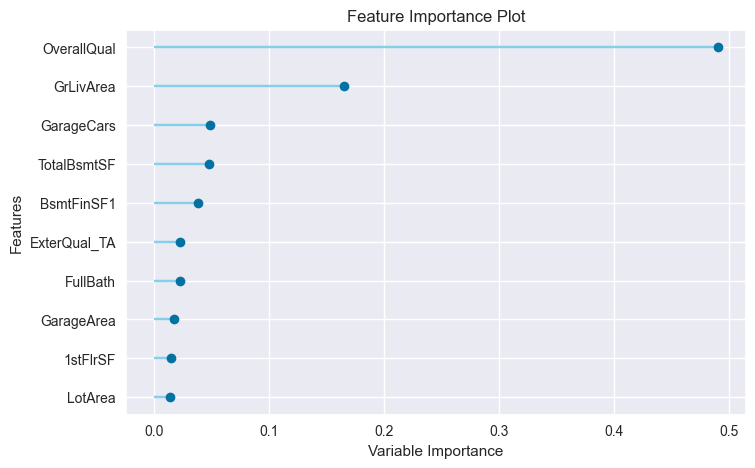

Nombre del modelo: LGBMRegressor(n_jobs=-1, random_state=2023)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,24847.9826,2535429824.4912,50353.0518,0.5011,0.2350,0.1610
1,15778.9963,695081637.4867,26364.4010,0.9103,0.1045,0.0800
2,19250.8844,1189293321.3177,34486.1323,0.8639,0.1369,0.0991
3,19994.2486,860774893.8529,29338.9655,0.8423,0.1693,0.1134
4,17289.1170,574603533.8924,23970.8893,0.8879,0.1192,0.0911
5,15229.0425,639722283.2201,25292.7318,0.8617,0.1574,0.1046
6,16768.2595,628098442.9925,25061.8922,0.8895,0.1300,0.0945
7,13502.0826,383067681.6937,19572.1149,0.9329,0.1317,0.0891
8,17405.0227,547415882.9908,23396.9204,0.9033,0.1310,0.0999


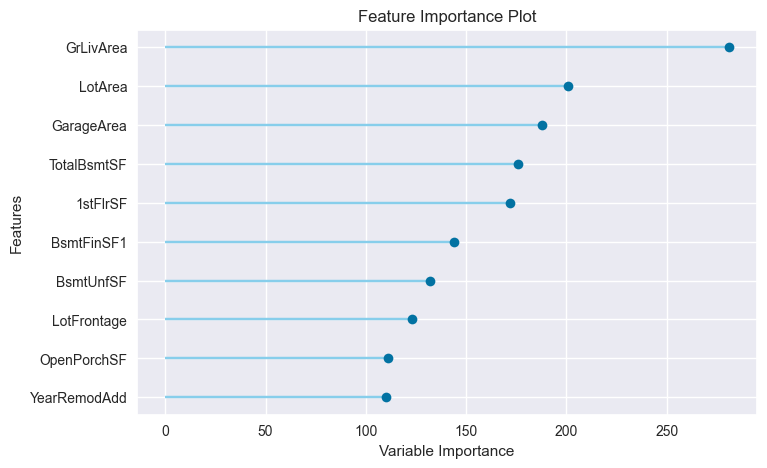

Nombre del modelo: RandomForestRegressor(n_jobs=-1, random_state=2023)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,24745.9622,2600963033.6357,50999.6376,0.4882,0.2408,0.1653
1,16050.3370,700926863.4593,26475.0234,0.9096,0.1114,0.0827
2,22381.2096,1386260076.2770,37232.5137,0.8414,0.1554,0.1140
3,18072.4074,675610763.7648,25992.5136,0.8762,0.1365,0.0990
4,18969.0561,720304238.7582,26838.4843,0.8595,0.1363,0.1005
5,16701.7890,618963020.8397,24878.9674,0.8662,0.1677,0.1176
6,17054.1370,594361538.8567,24379.5311,0.8954,0.1433,0.1075
7,14560.2258,394291489.8747,19856.7744,0.9309,0.1393,0.0988
8,17950.0498,566271461.2619,23796.4590,0.9000,0.1390,0.1076


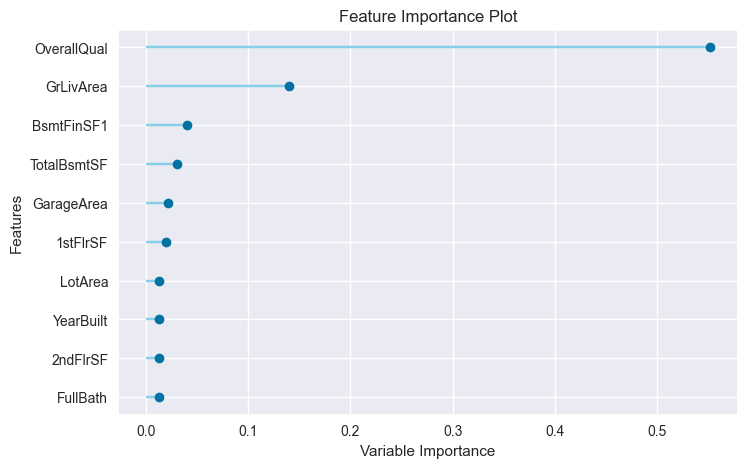

In [32]:
for model_name in top3:
    # Crear el modelo
    print(f'Nombre del modelo: {model_name}')
    model = create_model(model_name)

    # Crear el gráfico de importancia de características
    plot_model(model, plot='feature')
    model_name = model.__class__.__name__
    
    # Mostrar el gráfico modificado
    plt.show()

# Para el modelo 1 GBR y el modelo 3 RF hay 2 variables significativas que impactan en el resultado siendo OVERALLQUAL y GRLivArea las más importantes.
# Para el modelo 2 LGBMR hay 5 variables significativas y estas variables están relacionadas con el área de la propiedad, las cuales son:
    # GrLivArea
    # LotArea
    # GarageArea
    # TotalBsmtS
    # 1stFlrSF 
# La diferencia entre los modelos 1 y 3 son los valores de las métricas lo cual hace mejor al primero.

### Optimización de hiperparámetros

In [34]:
# Seleccionar los dos mejores modelos
top2 = compare_models(n_select=2)

# Optimizar hiperparámetros para los dos mejores modelos
top2 = [tune_model(model) for model in top2]

for model in top2:
    model_name = model.__class__.__name__
    print(f'Nombre del modelo: {model_name}')

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,08:53:45
Status,. . . . . . . . . . . . . . . . . .,Loading Estimator
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,17193.9936,771519086.4130,26188.2240,0.8659,0.1394,0.1019,0.6680
lightgbm,Light Gradient Boosting Machine,17799.6734,873304810.7908,28390.5482,0.8475,0.1455,0.1034,0.7530
rf,Random Forest Regressor,18430.5320,893253168.8116,28642.2567,0.8450,0.1515,0.1096,1.0200
et,Extra Trees Regressor,19554.1126,977741238.7974,30307.6230,0.8357,0.1525,0.1124,0.9120
en,Elastic Net,19487.2529,1065256898.6520,31440.6048,0.8160,0.1572,0.1113,0.5150
br,Bayesian Ridge,20083.5996,1105637601.5382,31678.5771,0.8061,0.1903,0.1184,0.4510
par,Passive Aggressive Regressor,19585.0552,1139595514.2704,32174.1291,0.8014,0.1637,0.1140,0.6260
omp,Orthogonal Matching Pursuit,21167.6448,1151069563.8980,32731.6181,0.7984,0.2082,0.1299,0.4940
huber,Huber Regressor,20060.7998,1168758324.9236,32099.4714,0.7948,0.1704,0.1197,0.4960
ada,AdaBoost Regressor,24272.7146,1252497484.3915,34616.6504,0.7834,0.1936,0.1539,0.5690


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,24569.6276,2921968638.5582,54055.2369,0.4250,0.2454,0.1653
1,16028.9353,668745680.7840,25860.1176,0.9137,0.1152,0.0848
2,23136.4451,1532730588.4177,39150.1033,0.8246,0.1457,0.1091
3,19586.3430,757589824.2413,27524.3497,0.8612,0.1555,0.1094
4,18567.0657,651468124.3010,25523.8736,0.8729,0.1322,0.0988
5,14531.6233,369613438.7294,19225.3333,0.9201,0.1494,0.1024
6,16837.8837,593887705.8480,24369.8114,0.8955,0.1348,0.0995
7,13010.5913,359514823.1370,18960.8761,0.9370,0.1248,0.0846
8,16835.3064,467876843.3313,21630.4610,0.9174,0.1210,0.0972


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,23962.5946,2420620096.6874,49199.7977,0.5236,0.2236,0.1472
1,17707.4751,791713541.8723,28137.4047,0.8979,0.1205,0.0918
2,20560.8557,1186071520.2411,34439.3891,0.8643,0.1332,0.1001
3,18748.7593,751810793.6135,27419.1684,0.8623,0.1505,0.1045
4,17872.8005,755826948.0742,27492.3071,0.8526,0.1289,0.0905
5,13806.3490,373524774.1138,19326.7890,0.9193,0.1615,0.1063
6,17162.8549,687360798.6224,26217.5666,0.8791,0.1446,0.1036
7,14717.0141,543963969.9400,23323.0352,0.9047,0.1325,0.0926
8,17131.1618,508394726.5227,22547.6102,0.9102,0.1360,0.1035


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
Nombre del modelo: GradientBoostingRegressor
Nombre del modelo: LGBMRegressor


In [35]:
# Los valores optimizados son mejores para GBR, entonces se hará ese modelo.
gbr= create_model('gbr')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,24352.7230,2570492282.0715,50700.0225,0.4942,0.2339,0.1585
1,16448.9799,513169642.3949,22653.2479,0.9338,0.1153,0.0898
2,20316.3193,1268522481.2025,35616.3232,0.8548,0.1310,0.0975
3,16962.3389,521280011.9863,22831.5574,0.9045,0.1381,0.0979
4,16464.2582,592288015.5359,24336.9681,0.8845,0.1204,0.0894
5,16011.2822,437322497.0094,20912.2571,0.9055,0.1528,0.1126
6,14908.3480,449795779.3361,21208.3894,0.9209,0.1266,0.0922
7,13622.4947,361717701.9557,19018.8775,0.9366,0.1180,0.0883
8,15668.2097,424228232.5200,20596.8015,0.9251,0.1256,0.0947


In [36]:
final_model=finalize_model(estimator='gbr')

In [37]:
#guardamos el modelo
save_model(model=final_model,model_name='../models/modelo_final')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['MSSubClass', 'LotFrontage',
                                              'LotArea', 'OverallQual',
                                              'OverallCond', 'YearBuilt',
                                              'YearRemodAdd', 'MasVnrArea',
                                              'BsmtFinSF1', 'BsmtFinSF2',
                                              'BsmtUnfSF', 'TotalBsmtSF',
                                              '1stFlrSF', '2ndFlrSF',
                                              'LowQualFinSF', 'GrLivArea',
                                              'BsmtFullBath', 'BsmtHalfBath',
                                              'FullBath', 'HalfBath...
                                                               use_cat_names=True))),
                 ('remove_multicollinearity',
                  TransformerWrapper(exclude=[],
 

In [38]:
#cargamos el modelo 
model= load_model('../models/modelo_final')

Transformation Pipeline and Model Successfully Loaded


In [39]:
predic= predict_model(model,data=data_test)
predic

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,15540.2746,484788469.5709,22017.9125,0.9185,0.1268,0.0955


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,prediction_label
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,5,2007,WD,Normal,181500,161467.080574
21,22,45,RM,57.0,7449,Pave,Grvl,Reg,Bnk,AllPub,...,NaN,GdPrv,NaN,0,6,2007,WD,Normal,139400,147221.059079
27,28,20,RL,98.0,11478,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,5,2010,WD,Normal,306000,307661.461245
29,30,30,RM,60.0,6324,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,5,2008,WD,Normal,68500,66150.256303
31,32,20,RL,NaN,8544,Pave,NaN,IR1,Lvl,AllPub,...,NaN,MnPrv,NaN,0,6,2008,WD,Normal,149350,142513.738251
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1447,1448,60,RL,80.0,10000,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,12,2007,WD,Normal,240000,268016.983283
1449,1450,180,RM,21.0,1533,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,8,2006,WD,Abnorml,92000,101030.559030
1451,1452,20,RL,78.0,9262,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,5,2009,New,Partial,287090,258006.968516
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,8,2007,WD,Normal,175000,164978.440034


In [40]:

y_true = predic['SalePrice']  # los valores reales 
y_pred = predic['prediction_label']  # nuestros predicciones

# Calculamos R2
r2 = r2_score(y_true, y_pred)

# Calculamos RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Calculamos MSE
mse = mean_squared_error(y_true, y_pred)

# Calculamos MAPE
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Imprimir métricas
print(f'R2: {r2}')
print(f'RMSE: {rmse}')
print(f'MSE: {mse}')
print(f'MAPE: {mape}%')


# 1.tiene un valor R2 alto y no se observa que tenga sobre ajuste
# 2.RMSE Y MSE Tienen un valor aceptable ya que los valores que se están estudiando son cantidades grandes.
# 3.MAPE tiene un porcentaje bajo lo cual indica que hay gran precisión en el modelo.

R2: 0.9184836905570928
RMSE: 22017.912470780135
MSE: 484788469.5709353
MAPE: 9.545600140937323%
